In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from pathlib import Path
from torch import Tensor

from tqdm import tqdm
from PIL import Image

import cv2
from torchvision.utils import make_grid
import albumentations as A
import albumentations.pytorch.transforms as Atf


import torch.nn as nn
import torch.nn.functional as F

from UNet import UNet
from Dataset import MyDataset
from FIsAllUNeed import show_img, dice_loss, compress_mask_C

/home/user/VirtualEnv/jupyter/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 1 NVIDIA GeForce RTX 2080 Ti


In [3]:
!pwd

/home/user/Workspace


In [17]:
root = r'dataset'
split = ['train','test']
IMG_SIZE = [800, 800]
BATCH_SIZE = 5
INIT_LR = 0.0001
EPOCHES = 3
amp = False

tds = MyDataset(root,
                split[0],
                A.Compose([
                            A.HorizontalFlip(p=0.5),
                            #Atf.ToTensorV2()
                            ],
                additional_targets={'image0': 'image', 'mask': 'image'}), IMG_SIZE = IMG_SIZE)

ttds = MyDataset(root, split[1], IMG_SIZE = IMG_SIZE)


In [18]:
print(len(tds))
print(len(ttds))

6546
2793


In [19]:
tdl = DataLoader(tds, batch_size=BATCH_SIZE, shuffle=True)
vdl = DataLoader(ttds, batch_size=1, shuffle=True)

In [41]:
a = next(iter(tdl))
print(a[0].shape)

torch.Size([5, 3, 800, 800])


torch.Size([5, 3, 800, 800])
after tensor(0.9059, dtype=torch.float64)
torch.Size([5, 1, 800, 800])
after tensor(7.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


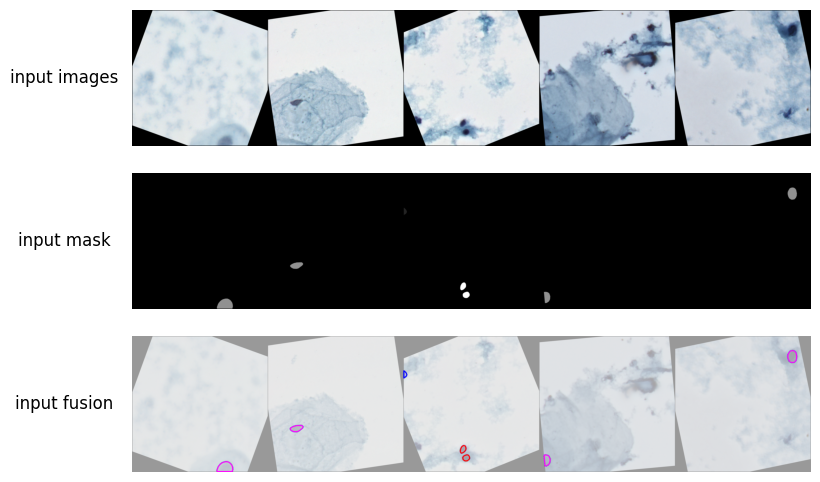

In [42]:
show_img(a[0], a[1].float(), img_size=IMG_SIZE)

In [9]:
weights_root = Path("weights_final")
weights_root.mkdir(exist_ok=True)
logs_root = Path("log")
logs_root.mkdir(exist_ok=True)

unet = UNet(n_channels=3, n_classes=8).to(device)

# unet = torch.nn.DataParallel(UNet(n_channels=3, n_classes=8).to(device),
#                              device_ids=[0]#, 3, 4, 5, 6, 7]
#                              )

opt = Adam(unet.parameters(), lr=INIT_LR)

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if UNet(n_channels=3, n_classes=8).n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0
H = {"train_loss": [], "test_loss": []}

In [10]:
sstartTime = time.time()
for epoch in range(1, EPOCHES + 1):
        unet.train()
        totalTrainLoss = torch.Tensor([0]).to(device)
        totalTestLoss = torch.Tensor([0]).to(device)
        with tqdm(total=len(tds), desc=f'Epoch {epoch}/{EPOCHES}', unit='img') as pbar:
            for batch in tdl:
                images, true_masks = batch[0], batch[1]

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = unet(images)
                    loss = criterion(masks_pred, true_masks.squeeze(1))
                    dice_losses = 0
                    for B_i in range(true_masks.shape[0]):
                        # print('pred',F.softmax(masks_pred[B_i], dim=1).shape)
                        # print('true',F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).shape)
                        dice_losses += dice_loss(
                            F.softmax(masks_pred[B_i].unsqueeze(0), dim=1).float(),
                            F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )
                    loss += dice_losses/true_masks.shape[0]

                opt.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1)
                grad_scaler.step(opt)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1

                totalTrainLoss += loss

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                # division_step = (len(tds) // (5 * BATCH_SIZE))

                # val


            with torch.no_grad():
                unet.eval()
                with tqdm(total=len(ttds), desc=f'Epoch {epoch}/{EPOCHES}', unit='img') as pbar:
                    for batch in vdl:

                        images, true_masks = batch[0], batch[1]

                        images = images.to(device=device, dtype=torch.float32)
                        true_masks = true_masks.to(device=device, dtype=torch.long)

                        masks_pred = unet(images)
                        test_loss = criterion(masks_pred, true_masks.squeeze(1))

                        dice_losses = 0
                        for B_i in range(true_masks.shape[0]):
                            # print('pred',F.softmax(masks_pred[B_i].unsqueeze(0), dim=1).shape)
                            # print('true',F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).shape)
                            dice_losses += dice_loss(
                                F.softmax(masks_pred[B_i].unsqueeze(0), dim=1).float(),
                                F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).float(),
                                multiclass=True
                            )
                        test_loss += dice_losses/true_masks.shape[0]

                        totalTestLoss += test_loss
                        #anno = all_metrics(pred, y, show=False)
                        pbar.update(images.shape[0])
                        pbar.set_postfix(**{'loss (batch)': test_loss.item()})

            # calculate the average training and validation loss
            avgTrainLoss = (totalTrainLoss.cpu().item() / len(tdl))
            avgTestLoss = (totalTestLoss.cpu().item() / len(vdl))
            # if H["test_loss"] and avgTestLoss < np.min(H["test_loss"]):
            torch.save(unet.state_dict(), f"{weights_root}/{avgTestLoss:.4f}_{epoch+1:03}.pth")
            # update our training history
            H["train_loss"].append(avgTrainLoss)
            H["test_loss"].append(avgTestLoss)
            np.save(r'log/train_loss', H["train_loss"])
            np.save(r'log/test_loss', H["test_loss"])
            # print the model training and validation information

In [11]:
weights_root = './weights_final'
weight = '0.0295_042.pth'
PATH = os.path.join(weights_root, weight)
#unet = UNet(n_channels=3, n_classes=8).to(device)
unet.load_state_dict(torch.load(PATH))
for batch in vdl:
    images, true_masks = batch[0], batch[1]

    images = images.to(device=device, dtype=torch.float32)
    true_masks = true_masks

    pred = unet(images)
    images = images.cpu()
    pred = pred.cpu()
    print(true_masks.dtype)
    print(pred.shape)
    break

torch.int64
torch.Size([1, 8, 1200, 1600])


/home/user/VirtualEnv/jupyter/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 3, 1200, 1600])
after tensor(0.8745)
torch.Size([1, 1, 1200, 1600])
after tensor(4.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 1200, 1600])
after tensor(7.)


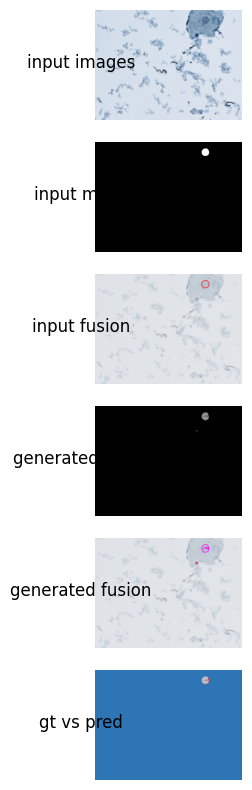

In [12]:
pred2show = compress_mask_C(pred, -1)
show_img(images, true_masks.float(), gen_masks=pred2show,img_size=[1200,1600] , mode=True)

In [13]:
test_loss = np.load(r'log/test_loss.npy', allow_pickle=True)

In [14]:
test_loss

array([0.04740079, 0.038266  , 0.03871048, 0.03837948, 0.03822225,
       0.03803108, 0.03792332, 0.03527694, 0.04439885, 0.03797148,
       0.03747144, 0.04113205, 0.03310704, 0.03742086, 0.03611924,
       0.03472059, 0.03433042, 0.03446579, 0.03489168, 0.03433472,
       0.03482079, 0.03272721, 0.03216562, 0.03455374, 0.04084138,
       0.03574431, 0.03283606, 0.03376184, 0.03022687, 0.03188328,
       0.03193408, 0.03489564, 0.03006209, 0.04173308, 0.03567521,
       0.09378677, 0.05238081, 0.03927795, 0.03094472, 0.03062848,
       0.02953688, 0.05131827, 0.02998515, 0.02822369, 0.03254902])

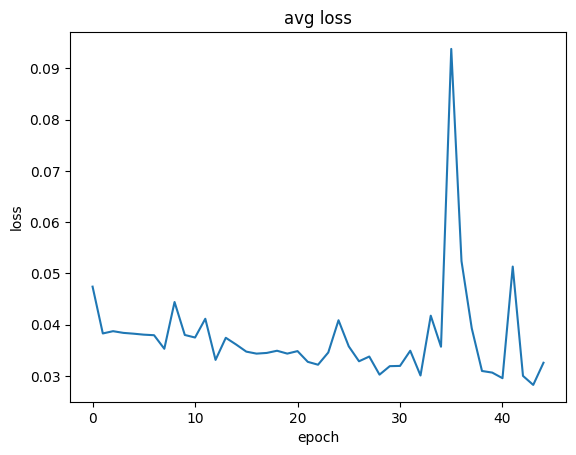

In [15]:
plt.title("avg loss") # title
plt.ylabel("loss") # y label
plt.xlabel("epoch") # x label
plt.plot(list(range(len(test_loss))), test_loss, )

In [16]:
list(range(5))

[0, 1, 2, 3, 4]